In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import html

from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pointbiserialr

sns.set(style="whitegrid", context="talk", palette="deep")

# =====================================================
# 1. Paths & basic configuration
# =====================================================
root = Path("..").resolve() / "capstone_project"
raw_path = root / "data" / "raw" / "Adult Dataset"
processed_path = root / "data" / "processed"
processed_path.mkdir(parents=True, exist_ok=True)

REPORTS = root / "reports"
REPORTS.mkdir(parents=True, exist_ok=True)

VISUALS = root / "visuals"
VISUALS.mkdir(parents=True, exist_ok=True)

print(f"[Info] Root: {root}")
print(f"[Info] Processed path: {processed_path}")

# =====================================================
# 2. Load raw Adult dataset & initial cleaning
# =====================================================
columns = [
    "age","workclass",
    "fnlwgt","education",
    "education-num","marital-status",
    "occupation","relationship",
    "race","sex","capital-gain",
    "capital-loss","hours-per-week",
    "native-country","income",
]
in_file = raw_path / "adult_data.csv"
if not in_file.exists():
    raise FileNotFoundError(f"Input file not found: {in_file}")
df = pd.read_csv(
    in_file,
    names=columns,
    sep=",",
    skipinitialspace=True,
    na_values=["?"],
    low_memory=False,
)
# Trim whitespace in object columns
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip()
# Normalize target if it has trailing dots (common in adult.test)
if "income" in df.columns and df["income"].dtype == "object":
    df["income"] = df["income"].str.replace(r"\.$", "", regex=True)
# Remove duplicate rows
before = len(df)
df = df.drop_duplicates().copy()
print(f"[Info] Removed {before - len(df)} duplicate rows. Remaining: {len(df)}")
# Ensure numeric types for key numeric columns
numeric_cols_raw = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
df[numeric_cols_raw] = df[numeric_cols_raw].apply(pd.to_numeric, errors="coerce")
print("\n[Info] Missing values per column (before dropna):")
print(df.isna().sum())
# Drop rows with any missing values
df_before = df.shape[0]
df = df.dropna().copy()
print(f"\n[Info] Dropped {df_before - df.shape[0]} rows with missing values. Remaining: {df.shape[0]}")
print(f"[Info] Loaded rows: {df.shape[0]}, columns: {df.shape[1]}")
print("[Info] Target value counts (raw):")
print(df["income"].value_counts(dropna=False))
# Save an early-cleaned version
early_clean_path = processed_path / "adult.csv"
df.to_csv(early_clean_path, index=False)
print(f"\n[Info] Saved early-cleaned CSV to: {early_clean_path}")

# =====================================================
# 3. Target preparation
# =====================================================
TARGET_COL = "income"
HOURS_COL = "hours-per-week"
EDU_YEARS_COL = "education-num"
AGE_COL = "age"

# Clean up the target: unescape HTML, strip spaces, remove trailing dots
df[TARGET_COL] = (
    df[TARGET_COL]
    .astype(str)
    .apply(html.unescape)
    .str.strip()
    .str.replace(r"\.$", "", regex=True)
)

# Map to binary
mapping = {">50K": 1, "<=50K": 0}
df[TARGET_COL] = df[TARGET_COL].map(mapping)

# Check for unmapped labels
invalid_mask = df[TARGET_COL].isna()
if invalid_mask.any():
    print("\n[Warning] Unmapped target labels encountered (showing up to 10 examples):")
    print(df.loc[invalid_mask, TARGET_COL].head(10))
    print("Counts of unmapped labels:")
    print(df.loc[invalid_mask, TARGET_COL].value_counts(dropna=False))

# Drop rows with NaN in target
before = len(df)
df = df.dropna(subset=[TARGET_COL]).copy()
print(f"[Info] Dropped {before - len(df)} rows with NaN in target '{TARGET_COL}'.")

# Explicit dtype
df[TARGET_COL] = df[TARGET_COL].astype("int8")
print("[Info] Target distribution:")
print(df[TARGET_COL].value_counts())


[Info] Root: C:\Users\jayap\AI\capstone_project
[Info] Processed path: C:\Users\jayap\AI\capstone_project\data\processed
[Info] Removed 24 duplicate rows. Remaining: 32537

[Info] Missing values per column (before dropna):
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     582
income               0
dtype: int64

[Info] Dropped 2398 rows with missing values. Remaining: 30139
[Info] Loaded rows: 30139, columns: 15
[Info] Target value counts (raw):
income
<=50K    22633
>50K      7506
Name: count, dtype: int64

[Info] Saved early-cleaned CSV to: C:\Users\jayap\AI\capstone_project\data\processed\adult.csv
[Info] Dropped 0 rows with NaN in target 'income'.
[Info] Target distribution:
income
0    22633
1     7506
Name: count, dt

In [3]:

# =====================================================
# 4. Outlier removal & final clean dataset (df_clean)
# =====================================================
def iqr_filter(data: pd.DataFrame, col: str, k: float = 1.5) -> pd.DataFrame:
    Q1, Q3 = data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return data[(data[col] >= lower) & (data[col] <= upper)]

df_clean = df.copy()

# Apply IQR filter for selected continuous variables
for col in [AGE_COL, EDU_YEARS_COL, HOURS_COL]:
    if col in df_clean.columns and np.issubdtype(df_clean[col].dtype, np.number):
        before = df_clean.shape[0]
        df_clean = iqr_filter(df_clean, col, k=1.5)
        print(f"[Info] {col}: removed {before - df_clean.shape[0]} outliers (IQR rule).")

# Weekly hours sanity filter: 1–100
if HOURS_COL in df_clean.columns:
    before = df_clean.shape[0]
    df_clean = df_clean[(df_clean[HOURS_COL] >= 1) & (df_clean[HOURS_COL] <= 100)]
    print(f"[Info] {HOURS_COL} sanity filter: removed {before - df_clean.shape[0]} rows outside 1–100 hours.")

# Age sanity filter: 16–90
if AGE_COL in df_clean.columns:
    before = df_clean.shape[0]
    df_clean = df_clean[(df_clean[AGE_COL] >= 16) & (df_clean[AGE_COL] <= 90)]
    print(f"[Info] {AGE_COL} sanity filter: removed {before - df_clean.shape[0]} rows outside 16–90.")

print("[Info] Remaining rows after outlier removal:", df_clean.shape[0])

# Save final cleaned dataset
cleaned_path = processed_path / "adult_cleaned.csv"
df_clean.to_csv(cleaned_path, index=False)
print(f"[Info] Saved final cleaned CSV to: {cleaned_path}")


[Info] age: removed 168 outliers (IQR rule).
[Info] education-num: removed 190 outliers (IQR rule).
[Info] hours-per-week: removed 7784 outliers (IQR rule).
[Info] hours-per-week sanity filter: removed 0 rows outside 1–100 hours.
[Info] age sanity filter: removed 0 rows outside 16–90.
[Info] Remaining rows after outlier removal: 21997
[Info] Saved final cleaned CSV to: C:\Users\jayap\AI\capstone_project\data\processed\adult_cleaned.csv



=== RandomForest Classification report (test) ===
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4058
           1       0.71      0.61      0.65      1442

    accuracy                           0.83      5500
   macro avg       0.79      0.76      0.77      5500
weighted avg       0.83      0.83      0.83      5500

ROC-AUC (RandomForest): 0.889

=== 5-fold ROC-AUC (RandomForest) ===
Mean: 0.892 | Std: 0.005 | Scores: [0.901 0.888 0.886 0.89  0.893]
[Info] Saved: C:\Users\jayap\AI\capstone_project\reports\feature_importance_permutation_original_rf.csv

[Info] Importance of weekly working hours related features (engineered, RandomForest):
hours-per-week    0.004609
dtype: float64


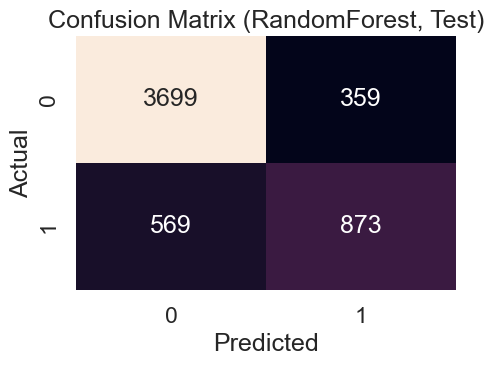

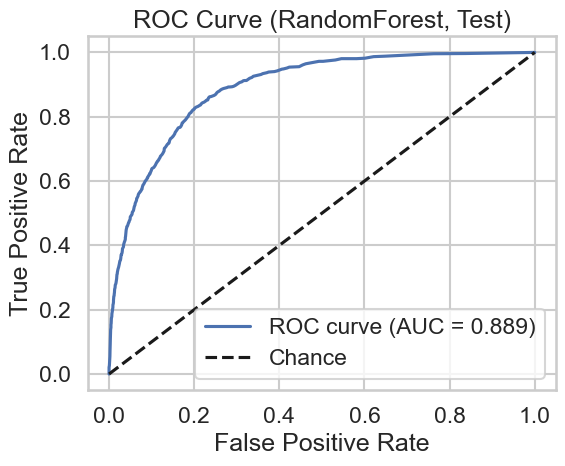

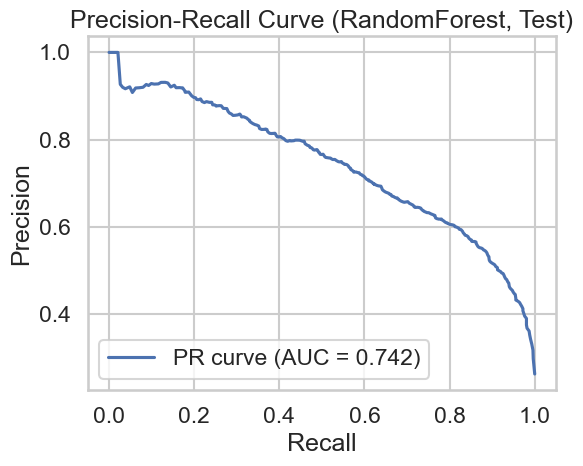

In [ ]:

# =====================================================
# 5. RandomForest model with preprocessing (df_clean)
# =====================================================
# Identify numeric vs categorical features from df_clean
num_cols = df_clean.select_dtypes(include=["int64", "float64", "int32", "float32", "int8"]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=["object", "category"]).columns.tolist()
# Remove target from feature lists
num_cols = [c for c in num_cols if c != TARGET_COL]
cat_cols = [c for c in cat_cols if c != TARGET_COL]

X_rf = df_clean.drop(columns=[TARGET_COL])
y_rf = df_clean[TARGET_COL]

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, [c for c in num_cols if c in X_rf.columns]),
        ("cat", categorical_transformer, [c for c in cat_cols if c in X_rf.columns]),
    ],
    remainder="drop",
)
clf_rf = Pipeline(steps=[
    ("preprocess", preprocessor_rf),
    ("model", RandomForestClassifier(
        n_estimators=300,random_state=42,
        class_weight="balanced",
        n_jobs=-1,
    )),
])

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.25, random_state=42, stratify=y_rf
)
clf_rf.fit(X_train_rf, y_train_rf)
y_pred_rf = clf_rf.predict(X_test_rf)
y_prob_rf = clf_rf.predict_proba(X_test_rf)[:, 1]
print("\n=== RandomForest Classification report (test) ===")
print(classification_report(y_test_rf, y_pred_rf))
roc_auc_rf = roc_auc_score(y_test_rf, y_prob_rf)
print(f"ROC-AUC (RandomForest): {roc_auc_rf:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test_rf, y_pred_rf)
fig_cm, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, ax=ax)
ax.set_title("Confusion Matrix (RandomForest, Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
fig_cm.tight_layout()
fig_cm.savefig(VISUALS / "confusion_matrix_rf.png", dpi=150)
# ROC curve
fpr, tpr, _ = roc_curve(y_test_rf, y_prob_rf)
roc_auc_rf = auc(fpr, tpr)
fig_roc, ax = plt.subplots(figsize=(6, 5))
ax.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_rf:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Chance")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve (RandomForest, Test)")
ax.legend(loc="lower right")
fig_roc.tight_layout()
fig_roc.savefig(VISUALS / "roc_curve_rf.png", dpi=150)

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test_rf, y_prob_rf)
pr_auc_rf = auc(rec, prec)
fig_pr, ax = plt.subplots(figsize=(6, 5))
ax.plot(rec, prec, label=f"PR curve (AUC = {pr_auc_rf:.3f})")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve (RandomForest, Test)")
ax.legend(loc="lower left")
fig_pr.tight_layout()
fig_pr.savefig(VISUALS / "pr_curve_rf.png", dpi=150)

# Cross-validated ROC-AUC for generalization check (RandomForest)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(clf_rf, X_rf, y_rf, cv=cv, scoring="roc_auc")
print(f"\n=== 5-fold ROC-AUC (RandomForest) ===")
print(f"Mean: {cv_scores_rf.mean():.3f} | Std: {cv_scores_rf.std():.3f} | Scores: {np.round(cv_scores_rf, 3)}")
# Permutation importance (original engineered features) for Logistic Regression
result_rf = permutation_importance(
    clf_rf,
    X_test_rf,
    y_test_rf,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc",
)
feature_names_rf = X_test_rf.columns
importances_rf = pd.Series(result_rf.importances_mean, index=feature_names_rf).sort_values(ascending=False)
fi_path = REPORTS / "feature_importance_permutation_original_rf.csv"
importances_rf.to_csv(fi_path)
print(f"[Info] Saved: {fi_path}")

# Hours-related importance in engineered space
hours_related_rf = importances_rf[importances_rf.index.str.contains(r"hours-per-week|hours_bin", case=False, regex=True)]
print("\n[Info] Importance of weekly working hours related features (engineered, RandomForest):")
print(hours_related_rf)

In [5]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc_rf = accuracy_score(y_test_rf, y_pred_rf)
prec_rf = precision_score(y_test_rf, y_pred_rf)
rec_rf = recall_score(y_test_rf, y_pred_rf)
f1_rf = f1_score(y_test_rf, y_pred_rf)

print(f"\nAccuracy : {acc_rf:.3f}")
print(f"Precision: {prec_rf:.3f}")
print(f"Recall   : {rec_rf:.3f}")
print(f"F1-score : {f1_rf:.3f}")

# Save RandomForest model
models_dir = root / "models"
models_dir.mkdir(parents=True, exist_ok=True)
model_path = models_dir / "rf_adult.pkl"
joblib.dump(clf_rf, model_path)
print(f"\n[Info] RandomForest model saved to: {model_path}")
print(f"[Info] Reports saved to: {REPORTS}")



Accuracy : 0.831
Precision: 0.709
Recall   : 0.605
F1-score : 0.653

[Info] RandomForest model saved to: C:\Users\jayap\AI\capstone_project\models\rf_adult.pkl
[Info] Reports saved to: C:\Users\jayap\AI\capstone_project\reports


In [1]:

# =====================================================
# 6. Permutation importance (original feature space) & PDP
# =====================================================
# A) Permutation importance using original column names
feature_names_orig = X_test_rf.columns.to_list()

r_orig = permutation_importance(
    clf_rf,
    X_test_rf,
    y_test_rf,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc",
)

importances_orig = pd.DataFrame({
    "feature": feature_names_orig,
    "importance_mean": r_orig.importances_mean,
    "importance_std": r_orig.importances_std,
}).sort_values("importance_mean", ascending=False)

print("\n[Info] Top 15 permutation importances (original features):")
print(importances_orig.head(15))

# Highlight weekly working hours
hours_imp_orig = importances_orig.loc[importances_orig["feature"] == HOURS_COL]
print("\n[Info] Weekly working hours importance (original feature space):")
print(hours_imp_orig)

importances_orig.to_csv(REPORTS / "permutation_importance_original_rf.csv", index=False)
print(f"[Info] Saved: {REPORTS / 'permutation_importance_original_rf.csv'}")

# B) Partial Dependence Plot for HOURS_COL
# Ensure numeric dtype for numeric columns
for col in numeric_cols_raw:
    if col in X_test_rf.columns:
        X_test_rf[col] = pd.to_numeric(X_test_rf[col], errors="coerce").astype(float)

fig, ax = plt.subplots(figsize=())
try:
    PartialDependenceDisplay.from_estimator(
        clf_rf,
        X_test_rf,
        [HOURS_COL],
        kind="average",
        ax=ax,
    )
    plt.title("Partial Dependence: Weekly Working Hours vs Earning Probability (RandomForest)")
    plt.tight_layout()
    plt.savefig(VISUALS / "pdp_hours_per_week_rf.png", dpi=150)
    plt.show()
except Exception as e:
    print("[Warning] PDP could not be plotted for HOURS_COL:", e)

# =====================================================
# 7. Permutation importance in transformed (OHE) space (RandomForest)
# =====================================================
preproc_rf = clf_rf.named_steps["preprocess"]
model_rf = clf_rf.named_steps["model"]

# Transform X_test into numeric/OHE matrix
X_test_trans_rf = preproc_rf.transform(X_test_rf)

# Get transformed feature names
try:
    feature_names_trans_rf = preproc_rf.get_feature_names_out()
except Exception:
    # Fallback: manual construction
    num_features = preproc_rf.transformers_[0][2]
    cat_features = preproc_rf.transformers_[1][2]
    ohe = preproc_rf.named_transformers_["cat"]
    cat_ohe_names = ohe.get_feature_names_out(cat_features)
    feature_names_trans_rf = np.concatenate(
        [np.array(num_features, dtype=object), cat_ohe_names]
    )

assert X_test_trans_rf.shape[1] == len(feature_names_trans_rf), (
    f"Transformed shape {X_test_trans_rf.shape[1]} != names {len(feature_names_trans_rf)}"
)

r_trans = permutation_importance(
    model_rf,
    X_test_trans_rf,
    y_test_rf,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc",
)

importances_trans = pd.DataFrame({
    "feature": feature_names_trans_rf,
    "importance_mean": r_trans.importances_mean,
    "importance_std": r_trans.importances_std,
}).sort_values("importance_mean", ascending=False)

print("\n[Info] Top 15 permutation importances (transformed features):")
print(importances_trans.head(15))

importances_trans.to_csv(REPORTS / "permutation_importance_transformed_rf.csv", index=False)
print(f"[Info] Saved: {REPORTS / 'permutation_importance_transformed_rf.csv'}")

# Try to locate HOURS_COL in numeric block
try:
    num_features = preproc_rf.transformers_[0][2]
    if HOURS_COL in num_features:
        hours_idx = num_features.index(HOURS_COL)
        hours_imp_trans = importances_trans.iloc[[hours_idx]]
        print("\n[Info] Weekly working hours importance (transformed space, numeric index-based):")
        print(hours_imp_trans)
    else:
        print(f"[Info] {HOURS_COL} not in numeric features list: {num_features}")
except Exception as e:
    print("[Warning] Could not locate HOURS_COL index in transformed space:", e)


NameError: name 'X_test_rf' is not defined

In [11]:

# =====================================================
# 8. Correlation & Mutual Information (RandomForest input)
# =====================================================
# Point-biserial correlation for numeric features
feature_names_num = [c for c in num_cols if c in X_rf.columns]

df_corr = X_rf.copy()
df_corr[TARGET_COL] = y_rf

pbs_results = []
for col in feature_names_num:
    try:
        r_val, p_val = pointbiserialr(df_corr[col].astype(float), df_corr[TARGET_COL].astype(int))
        pbs_results.append((col, r_val, p_val))
    except Exception:
        pbs_results.append((col, np.nan, np.nan))

pbs_df = (
    pd.DataFrame(pbs_results, columns=["feature", "point_biserial_r", "p_value"])
    .sort_values("point_biserial_r", ascending=False)
    .reset_index(drop=True)
)

print("\n[Info] Point-biserial correlation (numeric features):")
print(pbs_df)

pbs_path = REPORTS / "point_biserial_correlations_rf.csv"
pbs_df.to_csv(pbs_path, index=False)
print(f"[Info] Saved: {pbs_path}")

# Mutual information on transformed features
X_trans_rf = preproc_rf.transform(X_rf)

try:
    feature_names_trans_rf_all = preproc_rf.get_feature_names_out()
except Exception:
    feature_names_trans_rf_all = feature_names_trans_rf  # from earlier

mi_vals = mutual_info_classif(
    X_trans_rf,
    y_rf,
    random_state=42,
    discrete_features=False,
)

mi_df = (
    pd.DataFrame({"feature": feature_names_trans_rf_all, "mutual_info": mi_vals})
    .sort_values("mutual_info", ascending=False)
    .reset_index(drop=True)
)

print("\n[Info] Mutual Information (top 20 transformed features, RF):")
print(mi_df.head(20))

mi_path = REPORTS / "mutual_information_features_rf.csv"
mi_df.to_csv(mi_path, index=False)
print(f"[Info] Saved: {mi_path}")



[Info] Point-biserial correlation (numeric features):
          feature  point_biserial_r        p_value
0   education-num          0.326113   0.000000e+00
1             age          0.254569  2.075076e-322
2    capital-gain          0.212685  2.063087e-223
3  hours-per-week          0.194300  4.339623e-186
4    capital-loss          0.140253   4.957321e-97
5          fnlwgt         -0.007422   2.710344e-01
[Info] Saved: C:\Users\jayap\AI\capstone_project\reports\point_biserial_correlations_rf.csv

[Info] Mutual Information (top 20 transformed features, RF):
                                   feature  mutual_info
0   cat__marital-status_Married-civ-spouse     0.102836
1                        num__capital-gain     0.084300
2                cat__relationship_Husband     0.078805
3                       num__education-num     0.059185
4                                 num__age     0.057781
5        cat__marital-status_Never-married     0.056491
6                        num__capital-loss

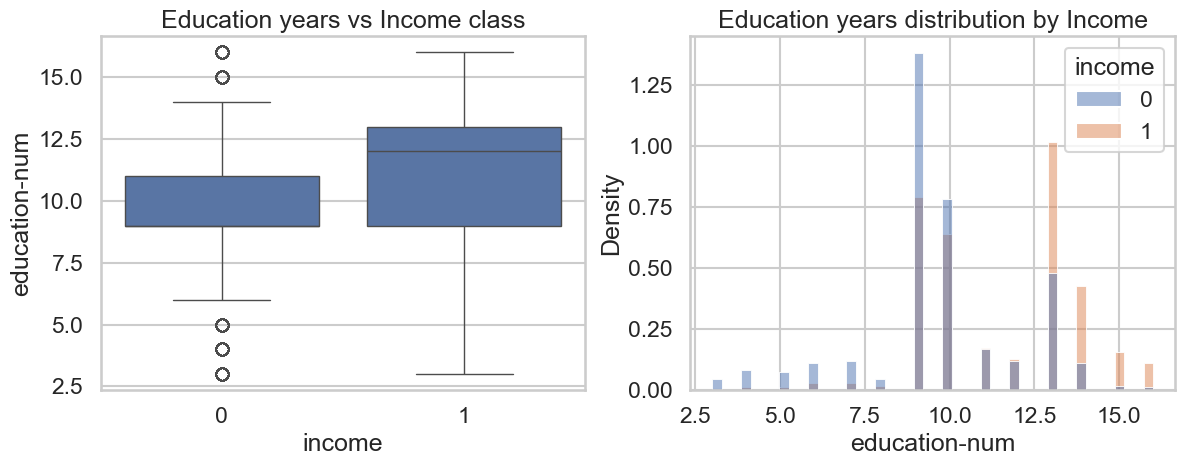

[Info] Estimated odds ratio per 1 std increase in education-num: 2.348


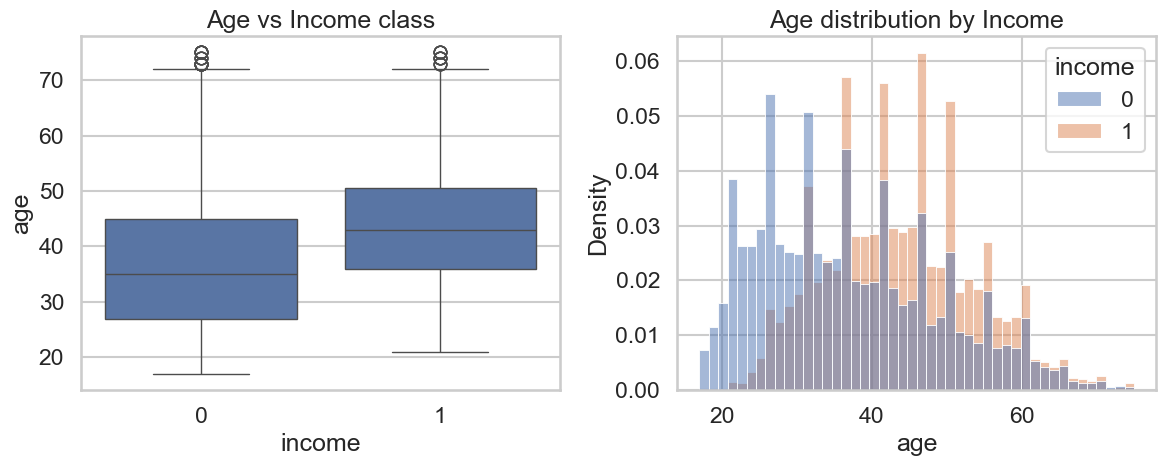

[Info] Estimated odds ratio per 1 std increase in age: 1.796


In [8]:

# =====================================================
# 9. Education & Age vs earning potential (using df_clean)
# =====================================================
# Education vs income
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df_clean, x=TARGET_COL, y=EDU_YEARS_COL, ax=ax[0])
ax[0].set_title("Education years vs Income class")

sns.histplot(
    data=df_clean,
    x=EDU_YEARS_COL,
    hue=TARGET_COL,
    stat="density",
    common_norm=False,
    ax=ax[1],
)
ax[1].set_title("Education years distribution by Income")
plt.tight_layout()
plt.savefig(VISUALS / "education_vs_income.png", dpi=150)
plt.show()

X_edu = df_clean[[EDU_YEARS_COL]]
y_bin = df_clean[TARGET_COL]
edu_clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
edu_clf.fit(X_edu, y_bin)
coef_edu = edu_clf.named_steps["logisticregression"].coef_[0][0]
odds_ratio_edu = np.exp(coef_edu)
print(f"[Info] Estimated odds ratio per 1 std increase in {EDU_YEARS_COL}: {odds_ratio_edu:.3f}")

# Age vs income
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df_clean, x=TARGET_COL, y=AGE_COL, ax=ax[0])
ax[0].set_title("Age vs Income class")

sns.histplot(
    data=df_clean,
    x=AGE_COL,
    hue=TARGET_COL,
    stat="density",
    common_norm=False,
    ax=ax[1],
)
ax[1].set_title("Age distribution by Income")
plt.tight_layout()
plt.savefig(VISUALS / "age_vs_income.png", dpi=150)
plt.show()

X_age = df_clean[[AGE_COL]]
age_clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
age_clf.fit(X_age, y_bin)
coef_age = age_clf.named_steps["logisticregression"].coef_[0][0]
odds_ratio_age = np.exp(coef_age)
print(f"[Info] Estimated odds ratio per 1 std increase in {AGE_COL}: {odds_ratio_age:.3f}")


[Info] Dropped 0 rows with NaN in target after feature engineering.

=== Logistic Regression Classification report (test) ===
              precision    recall  f1-score   support

           0     0.9303    0.7979    0.8590      3246
           1     0.5941    0.8319    0.6931      1154

    accuracy                         0.8068      4400
   macro avg     0.7622    0.8149    0.7761      4400
weighted avg     0.8421    0.8068    0.8155      4400


=== 5-fold ROC-AUC (Logistic Regression) ===
Mean: 0.906 | Std: 0.004 | Scores: [0.914 0.903 0.905 0.904 0.906]
[Info] Saved: C:\Users\jayap\AI\capstone_project\reports\feature_importance_permutation_original_logreg.csv

[Info] Importance of weekly working hours related features (engineered, Logistic Regression):
hours-per-week    0.001094
hours_bin         0.000214
dtype: float64

[Info] Logistic Regression model saved to: C:\Users\jayap\AI\capstone_project\models\logreg_adult.pkl
[Info] Reports saved to: C:\Users\jayap\AI\capstone_project

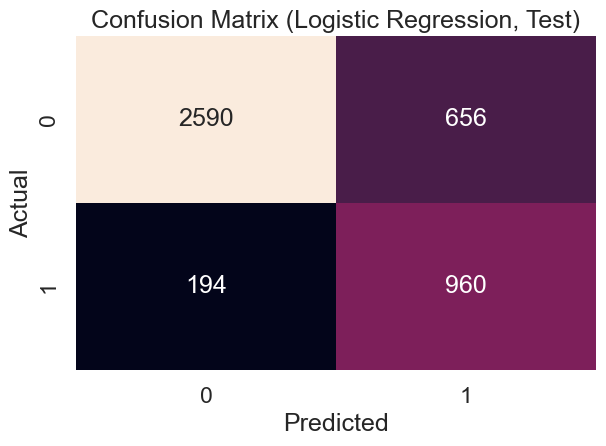

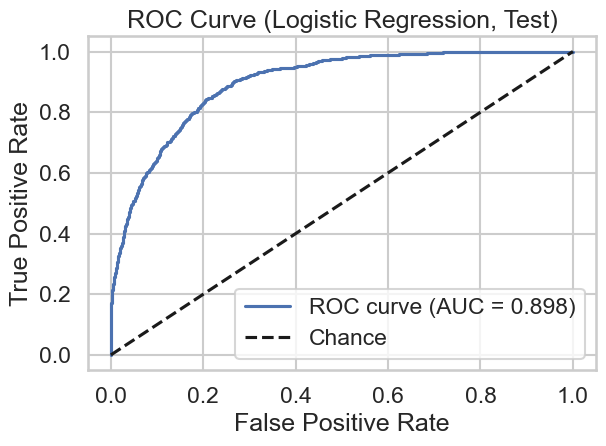

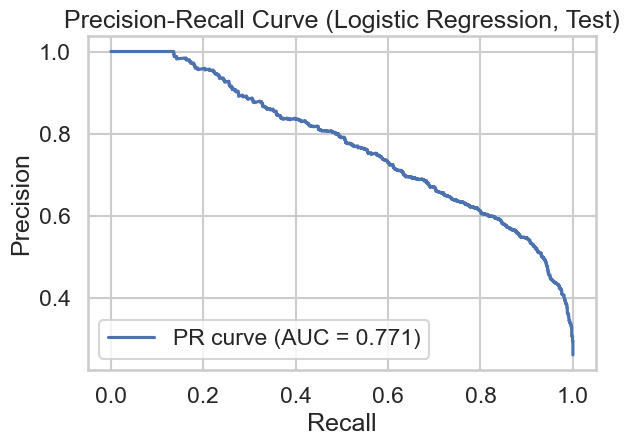

In [ ]:

# =====================================================
# 10. Feature Engineering + Logistic Regression model
# =====================================================
# Start from df_clean to add engineered features
df_fe = df_clean.copy()

# Binary flags
df_fe["is_married"] = df_fe["marital-status"].str.contains("Married", na=False).astype(int)
df_fe["has_capital_gain"] = (df_fe["capital-gain"] > 0).astype(int)
df_fe["has_capital_loss"] = (df_fe["capital-loss"] > 0).astype(int)

# Hours bins (domain-friendly)
def hours_bin(h):
    if pd.isna(h):
        return np.nan
    if h < 35:
        return "Part-time"
    elif h <= 40:
        return "Full-time"
    else:
        return "Overtime"

df_fe["hours_bin"] = df_fe[HOURS_COL].apply(hours_bin)

# Native country collapsed
df_fe["native_us"] = (df_fe["native-country"] == "United-States").astype(int)

# Age groups
df_fe["age_group"] = pd.cut(
    df_fe[AGE_COL],
    bins=[0, 24, 34, 44, 54, 64, 100],
    labels=["<=24", "25-34", "35-44", "45-54", "55-64", "65+"],
)

# Drop rows with NaNs caused by feature engineering
before = len(df_fe)
df_fe = df_fe.dropna(subset=[TARGET_COL]).copy()
print(f"[Info] Dropped {before - len(df_fe)} rows with NaN in target after feature engineering.")

# Drop textual education to avoid duplication
if "education" in df_fe.columns:
    df_fe = df_fe.drop(columns=["education"])

# Explicit target dtype
df_fe[TARGET_COL] = df_fe[TARGET_COL].astype("int8")

# Target and feature sets
y_lr = df_fe[TARGET_COL].astype(int)

numeric_features_lr = [
    "age","fnlwgt","education-num",
    "capital-gain","capital-loss",
    "hours-per-week","is_married",
    "has_capital_gain",
    "has_capital_loss","native_us",
]
categorical_features_lr = [
    "workclass","marital-status",
    "occupation","relationship",
    "race","sex","hours_bin",
    "age_group","native-country",
]

X_lr = df_fe[numeric_features_lr + categorical_features_lr]

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, y_lr, test_size=0.20, random_state=42, stratify=y_lr
)

preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_lr),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features_lr),
    ]
)

model_lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs",
)

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess_lr),
    ("model", model_lr),
])

# Train Logistic Regression model
pipe_lr.fit(X_train_lr, y_train_lr)

# Evaluation
y_pred_lr = pipe_lr.predict(X_test_lr)
y_prob_lr = pipe_lr.predict_proba(X_test_lr)[:, 1]

print("\n=== Logistic Regression Classification report (test) ===")
print(classification_report(y_test_lr, y_pred_lr, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test_lr, y_pred_lr)
fig_cm, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", cbar=False, ax=ax)
ax.set_title("Confusion Matrix (Logistic Regression, Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
fig_cm.tight_layout()
fig_cm.savefig(VISUALS / "confusion_matrix_logreg.png", dpi=150)

# ROC curve
fpr, tpr, _ = roc_curve(y_test_lr, y_prob_lr)
roc_auc_lr = auc(fpr, tpr)
fig_roc, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_lr:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Chance")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve (Logistic Regression, Test)")
ax.legend(loc="lower right")
fig_roc.tight_layout()
fig_roc.savefig(VISUALS / "roc_curve_logreg.png", dpi=150)

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test_lr, y_prob_lr)
pr_auc_lr = auc(rec, prec)
fig_pr, ax = plt.subplots()
ax.plot(rec, prec, label=f"PR curve (AUC = {pr_auc_lr:.3f})")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve (Logistic Regression, Test)")
ax.legend(loc="lower left")
fig_pr.tight_layout()
fig_pr.savefig(VISUALS / "pr_curve_logreg.png", dpi=150)

# Cross-validated ROC-AUC for generalization check (Logistic Regression)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_lr = cross_val_score(pipe_lr, X_lr, y_lr, cv=cv, scoring="roc_auc")
print(f"\n=== 5-fold ROC-AUC (Logistic Regression) ===")
print(f"Mean: {cv_scores_lr.mean():.3f} | Std: {cv_scores_lr.std():.3f} | Scores: {np.round(cv_scores_lr, 3)}")

# Permutation importance (original engineered features) for Logistic Regression
result_lr = permutation_importance(
    pipe_lr,X_test_lr,
    y_test_lr,n_repeats=10,
    random_state=42,
    scoring="roc_auc",
)

feature_names_lr = X_test_lr.columns
importances_lr = pd.Series(result_lr.importances_mean, index=feature_names_lr).sort_values(ascending=False)

fi_path = REPORTS / "feature_importance_permutation_original_logreg.csv"
importances_lr.to_csv(fi_path)
print(f"[Info] Saved: {fi_path}")

# Hours-related importance in engineered space
hours_related_lr = importances_lr[importances_lr.index.str.contains(r"hours-per-week|hours_bin", case=False, regex=True)]
print("\n[Info] Importance of weekly working hours related features (engineered, Logistic Regression):")
print(hours_related_lr)

# Save Logistic Regression model
models_dir = root / "models"
models_dir.mkdir(parents=True, exist_ok=True)
model_path = models_dir / "logreg_adult.pkl"
joblib.dump(pipe_lr, model_path)
print(f"\n[Info] Logistic Regression model saved to: {model_path}")
print(f"[Info] Reports saved to: {REPORTS}")



In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test_lr, y_pred_lr)
prec = precision_score(y_test_lr, y_pred_lr)
rec = recall_score(y_test_lr, y_pred_lr)
f1 = f1_score(y_test_lr, y_pred_lr)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
# =====================================================
# 11. Wrap-up: Save summary metrics
# =====================================================
summary = {
    "rows_after_cleaning": int(df_clean.shape[0]),
    "roc_auc_random_forest": float(roc_auc_rf),
    "roc_auc_logistic": float(roc_auc_lr),
    "pr_auc_logistic": float(pr_auc_lr),
    "hours_feature_in_dataset": HOURS_COL in df_clean.columns,
    "education_years_feature_in_dataset": EDU_YEARS_COL in df_clean.columns,
    "age_feature_in_dataset": AGE_COL in df_clean.columns,
}

summary_path = REPORTS / "summary_metrics.csv"
pd.Series(summary).to_csv(summary_path)
print(f"[Info] Saved summary metrics to: {summary_path}")


Accuracy : 0.807
Precision: 0.594
Recall   : 0.832
F1-score : 0.693


[Info] Saved summary metrics to: C:\Users\jayap\AI\capstone_project\reports\summary_metrics.csv


In [14]:
# generate_eda_6panel.py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk", palette="deep")

# === CONFIG ===
CLEANED_CSV = "../capstone_project/data/processed/adult_cleaned.csv"  # change if needed
OUT_DIR = "../capstone_project/visuals"
OUT_NAME = "EDA_6Panel_Visualization.png"
OUT_PATH = os.path.join(OUT_DIR, OUT_NAME)
DPI = 200

os.makedirs(OUT_DIR, exist_ok=True)

# === LOAD DATA ===
df = pd.read_csv(CLEANED_CSV)

# Ensure numeric types
for c in ["age", "education-num", "hours-per-week", "capital-gain", "capital-loss"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# If target is still text, map to 0/1
if "income" in df.columns and df["income"].dtype == object:
    df["income"] = df["income"].str.replace(r"\.$", "", regex=True).str.strip()
    df["income"] = df["income"].map({">50K": 1, "<=50K": 0})

# Small helpers for plotting
def pct_fmt(x, pos=None):
    return f"{int(x)}"

# === PLOT ===
fig, axes = plt.subplots(2, 3, figsize=(21,14))
axes = axes.ravel()

# 1) Age distribution
sns.histplot(df["age"].dropna(), bins=30, ax=axes[0], kde=False)
axes[0].set_title("Age distribution")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")

# 2) Education-num distribution
sns.histplot(df["education-num"].dropna(), bins=20, ax=axes[1], kde=False)
axes[1].set_title("Education-years (education-num)")
axes[1].set_xlabel("Education years")
axes[1].set_ylabel("Count")

# 3) Hours-per-week distribution (peak at 40)
sns.histplot(df["hours-per-week"].dropna(), bins=25, ax=axes[2], kde=False)
axes[2].set_title("Hours per week")
axes[2].set_xlabel("Hours/week")
axes[2].axvline(40, color="black", linestyle="--", linewidth=1)
axes[2].set_ylabel("Count")

# 4) Income vs Age (boxplot)
sns.boxplot(x=df["income"].map({0:"<=50K", 1:">50K"}), y=df["age"], ax=axes[3])
axes[3].set_title("Age by Income class")
axes[3].set_xlabel("Income")
axes[3].set_ylabel("Age")

# 5) Income vs Education-num (boxplot)
sns.boxplot(x=df["income"].map({0:"<=50K", 1:">50K"}), y=df["education-num"], ax=axes[4])
axes[4].set_title("Education years by Income class")
axes[4].set_xlabel("Income")
axes[4].set_ylabel("Education years")

# 6) Capital-gain distribution (log scale for non-zero)
# show zeros separately and log-scale histogram for non-zero values
cap_nonzero = df.loc[df["capital-gain"] > 0, "capital-gain"].dropna()
if len(cap_nonzero) > 0:
    axes[5].hist(np.log1p(cap_nonzero), bins=30)
    axes[5].set_title("Capital-gain (log(1+x) of >0 values)")
    axes[5].set_xlabel("log(1 + capital-gain)")
    axes[5].set_ylabel("Count")
else:
    axes[5].text(0.5, 0.5, "Most capital-gain == 0\nNo non-zero values to plot",
                 ha="center", va="center", fontsize=12)
    axes[5].set_axis_off()

plt.tight_layout()
plt.subplots_adjust(top=0.94)
fig.suptitle("Figure 2: EDA Overview — Key Distributions and Income Relations", fontsize=18)

# Save
plt.savefig(OUT_PATH, dpi=DPI, bbox_inches="tight")
print(f"Saved EDA figure to: {OUT_PATH}")
plt.close(fig)


Saved EDA figure to: ../capstone_project/visuals\EDA_6Panel_Visualization.png


In [20]:
# generate_three_plots.py
# Generates 3 PNGs:
#  - outlier_distribution.png
#  - mutual_information.png
#  - additional_stats.png
#
# Usage:
#   python generate_three_plots.py

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

sns.set(style="whitegrid", context="talk", palette="deep")

# ===== CONFIG =====
CLEANED_CSV = r"C:\Users\jayap\AI\capstone_project\data\processed\adult_cleaned.csv"
OUT_DIR = r"C:\Users\jayap\AI\capstone_project\visuals"
os.makedirs(OUT_DIR, exist_ok=True)
DPI = 200

# ===== LOAD =====
df = pd.read_csv(CLEANED_CSV)

# Ensure numeric columns exist and are numeric
num_cols = ["age", "education-num", "hours-per-week", "capital-gain", "capital-loss"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Map income to 0/1 if needed
if "income" in df.columns and df["income"].dtype == object:
    df["income"] = df["income"].astype(str).str.replace(r"\.$", "", regex=True).str.strip()
    df["income"] = df["income"].map({">50K": 1, "<=50K": 0})

# ===== PNG 1: Outlier Distribution (3-panel boxplots) =====
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y=df["age"].dropna(), ax=axes[0])
axes[0].set_title("Age Outlier Boxplot")
axes[0].set_xlabel("")
axes[0].set_ylabel("Age")

sns.boxplot(y=df["education-num"].dropna(), ax=axes[1])
axes[1].set_title("Education-num Outlier Boxplot")
axes[1].set_xlabel("")
axes[1].set_ylabel("Education years")

sns.boxplot(y=df["hours-per-week"].dropna(), ax=axes[2])
axes[2].set_title("Hours-per-week Outlier Boxplot")
axes[2].set_xlabel("")
axes[2].set_ylabel("Hours/week")

plt.tight_layout()
out1 = os.path.join(OUT_DIR, "outlier_distribution.png")
plt.savefig(out1, dpi=DPI, bbox_inches="tight")
plt.close()
print("Saved:", out1)

# ===== PNG 2: Mutual Information Barplot =====
# Prepare transformed features: use numeric + simple ordinal encoding for a few categoricals if present
X_mi = df.copy()
y_mi = X_mi["income"].astype(int) if "income" in X_mi.columns else None

# For mutual_info_classif we need numeric matrix: encode a few categorical columns coarsely
cat_cols = X_mi.select_dtypes(include=["object", "category"]).columns.tolist()
# choose small set of categorical columns if present to avoid explosion
cat_cols = [c for c in cat_cols if c in ["workclass", "occupation", "marital-status", "relationship", "race", "sex", "native-country"]]
X_mi_enc = X_mi[num_cols].copy()
for c in cat_cols:
    X_mi_enc[c] = X_mi[c].astype("category").cat.codes

# Remove rows with NaNs in X or y
mi_mask = X_mi_enc.notna().all(axis=1)
if y_mi is not None:
    mi_mask &= y_mi.notna()
X_mi_enc = X_mi_enc.loc[mi_mask]
y_mi = y_mi.loc[mi_mask]

mi_vals = mutual_info_classif(X_mi_enc, y_mi, random_state=42, discrete_features='auto')
mi_index = X_mi_enc.columns.tolist()
mi_series = pd.Series(mi_vals, index=mi_index).sort_values(ascending=False)

# plot top 8 features (or fewer)
top_n = min(8, len(mi_series))
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=mi_series.values[:top_n], y=mi_series.index[:top_n], ax=ax)
ax.set_title("Mutual Information (top features)")
ax.set_xlabel("Mutual Information")
ax.set_ylabel("Feature")
plt.tight_layout()
out2 = os.path.join(OUT_DIR, "mutual_information.png")
plt.savefig(out2, dpi=DPI, bbox_inches="tight")
plt.close()
print("Saved:", out2)

# ===== PNG 3: Additional Statistical Insights (3-panel counts) =====
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Income distribution
if "income" in df.columns:
    sns.countplot(x=df["income"].map({0:"<=50K", 1:">50K"}), ax=axes[0])
    axes[0].set_title("Income Distribution")
    axes[0].set_xlabel("Income")
else:
    axes[0].text(0.5, 0.5, "Income not available", ha="center")

# Age group distribution (<=35 / 36+)
age_group = np.where(df["age"] >= 35, "35+", "≤34")
sns.countplot(x=age_group, ax=axes[1])
axes[1].set_title("Age group distribution")
axes[1].set_xlabel("Age group")

# Education category: high vs low (>=12 yrs)
edu_cat = np.where(df["education-num"] >= 12, "High Edu (>=12)", "Low Edu (<12)")
sns.countplot(x=edu_cat, ax=axes[2])
axes[2].set_title("Education categories")
axes[2].set_xlabel("Education")

plt.tight_layout()
out3 = os.path.join(OUT_DIR, "additional_stats.png")
plt.savefig(out3, dpi=DPI, bbox_inches="tight")
plt.close()
print("Saved:", out3)

print("All images created in:", OUT_DIR)


Saved: C:\Users\jayap\AI\capstone_project\visuals\outlier_distribution.png
Saved: C:\Users\jayap\AI\capstone_project\visuals\mutual_information.png
Saved: C:\Users\jayap\AI\capstone_project\visuals\additional_stats.png
All images created in: C:\Users\jayap\AI\capstone_project\visuals


In [24]:
r_orig = permutation_importance(clf_rf, X_test_rf, y_test_rf, n_repeats=10, random_state=42, scoring="roc_auc")
importances = pd.Series(r_orig.importances_mean, index=feature_names_orig).sort_values(ascending=False)
hours_imp = importances.get("hours-per-week", None)
print("hours AUC drop:", hours_imp)


hours AUC drop: 0.004608719681128382


In [23]:
coef_edu = edu_clf.named_steps["logisticregression"].coef_[0][0]
odds_ratio_edu = np.exp(coef_edu)
coef_age = age_clf.named_steps["logisticregression"].coef_[0][0]
odds_ratio_age = np.exp(coef_age)
print(odds_ratio_edu, odds_ratio_age)


2.3476051854815845 1.796366720401512


In [25]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
print(classification_report(y_test_lr, y_pred_lr, digits=4))
roc_auc = roc_auc_score(y_test_lr, y_prob_lr)
cm = confusion_matrix(y_test_lr, y_pred_lr)
print("ROC AUC:", roc_auc)
print("Confusion matrix:\n", cm)


              precision    recall  f1-score   support

           0     0.9303    0.7979    0.8590      3246
           1     0.5941    0.8319    0.6931      1154

    accuracy                         0.8068      4400
   macro avg     0.7622    0.8149    0.7761      4400
weighted avg     0.8421    0.8068    0.8155      4400

ROC AUC: 0.8977402930790168
Confusion matrix:
 [[2590  656]
 [ 194  960]]


In [26]:
from sklearn.metrics import auc, precision_recall_curve
prec, rec, _ = precision_recall_curve(y_test_lr, y_prob_lr)
pr_auc = auc(rec, prec)
print("PR-AUC:", pr_auc)


PR-AUC: 0.7710527095316329
